# Architecture

#### face_detector
- requests the most recently captured frame when it is ready to process (previous process is complete)
- has latency (100ms)
- 5hz

#### pose_detector
- requests the most recently captured frame at slow fixed rate
- has latency (200ms)
- 1hz

#### face_recognition
- Requested when poor coresponces need additional data
- has latency (~ms)

#### correspondence
- 

#### kalman_filter
- Run prediction update when a new frame comes in from the FrameServer
- Maintain a buffer of preditions and uncertainty since the last measurement update
    - Fixed length buffer of say ~5s of measurements (150 slots)
    - If the buffer runs out, drop the tracked object
- When new data comes in, current predition path is overwriten by running back through the buffer and running a measurement update on the data from the past.
- Itterate prediction updates across stored times from the previous buffer up to the current frame accounting for latency


## Kalman Filter Math

![alt text](notebook_files/kalman_functions.png "Title")

a = x, b = x', c = y, d = y', e = d, f = d'

- derivative of b*t+tan(atan(a/e)+w)*e+a*cos(-r)-c*sin(-r)-a with respect to x
- d/da = -1 + cos(r) + 1/((1 + a^2/e^2) cos^2(w + tan^(-1)(a/e)))
- d/db = dt
- d/dc = sin(r)
- d/dd = 0
- d/de = -(a e)/((a^2 + e^2) cos^2(w + tan^(-1)(a/e))) + sin(w + tan^(-1)(a/e))/cos(w + tan^(-1)(a/e))
- d/df = 0


- derivative of d*t+tan(atan(c/e)+p)*e+a*cos(-r)-c*sin(-r)-c with respect to x
- d/da = cos(r)
- d/db = 0
- d/dc = -1 + sin(r) + 1/((1 + c^2/e^2) cos^2(p + tan^(-1)(c/e)))
- d/dd = dt
- d/de = -(c e)/((c^2 + e^2) cos^2(p + tan^(-1)(c/e))) + sin(p + tan^(-1)(c/e))/cos(p + tan^(-1)(c/e))
- d/df = 0


In [1]:
%load_ext autoreload
%autoreload

%matplotlib notebook

import matplotlib.pyplot as plt 
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(8,4.5)) #(6.4, 3.6)) #(16x9)/2.5
ax = fig.add_subplot(111)
plt.ion()

fig.show()

In [ ]:
import time
import math
import numpy as np

import multiprocessing as mp

from graphics import Graphics
from measurement import MeasGenerator

class FakeFrameDriver(mp.Process):
    def __init__(self,,settings):
        super(FakeFrameDriver,self).__init__()
        self.period = 0.05
        
        self.meas = MeasGenerator(settings['data'])
        self.start()
        
    def run(self):
        while ((time.time()-param_time_start) < 15):
            time_begin = time.time()
            data = self.meas.getData(time_begin-time_start)
            
            time.sleep(max(0,self.period-(time.time()-time_begin)))


class FaceDetector(mp.Process):
    def __init__(self,result_queue_):
        super(FaceDetector,self).__init__()
        self.result_queue = result_queue_


class FaceTracker():
    def __init__(self,x_start=np.array([0,0,0,0,0,0])):
        buffer_length = 200
        frame_shape = (1080,1920)
        aov = math.radians(72)
        
        self.x_buffer = np.zeros(6,buffer_length)
        self.u_buffer = np.zeros(3,buffer_length)
        
        self.i_pre = 0
        self.i_cur = 1
        self.x_buffer[:,self.i_pre] = x_start
        
        self.fov_lx = (frame_shape[1]/(2*math.tan(aov/2)))
        self.fov_ly = (frame_shape[0]/(2*math.tan(aov/2)))
                 
    def calculateG(self):
        # Pre-calculate various co-efficients
        x_0_2 = self.x_buffer[0,self.i_pre]**2
        x_2_2 = self.x_buffer[2,self.i_pre]**2
        x_4_2 = self.x_buffer[4,self.i_pre]**2
        r_0_i = self.u_buffer[2,self.i_cur]+math.atan(self.x_buffer[0,self.i_pre]/self.x_buffer[4,self.i_pre])
        r_2_i = self.u_buffer[1,self.i_cur]+math.atan(self.x_buffer[2,self.i_pre]/self.x_buffer[4,self.i_pre])
        
        # Build the matrix
        G = np.zeros(6,6)
        G[0,0] = -1+math.cos(u_buffer[0,self.i_cur])+(1/((1+(x_0_2/x_4_2))*(math.cos(r_0_i)**2)))
        G[0,1] = self.dt
        G[0,2] = math.sin(u_buffer[0,self.i_cur])
        G[0,4] = -((self.x_buffer[0,self.i_pre]*self.x_buffer[4,self.i_pre])/((x_0_2+x_4_2)*cos(r_0_i)**2))+(sin(r_0_i)/cos(r_0_i))
        G[1,1] = 1
        G[2,0] = math.cos(u_buffer[0,self.i_cur])
        G[2,2] = -1+sin(u_buffer[0,self.i_cur])+(1/((1+(x_2_2/x_4_2))*(math.cos(r_2_i)**2)))
        G[2,3] = self.dt
        G[2,4] = -((self.x_buffer[2,self.i_pre]*self.x_buffer[4,self.i_pre])/((x_2_2+x_4_2)*cos(r_2_i)**2))+(sin(r_2_i)/cos(r_2_i))
        G[3,3] = 1
        G[4,4] = 1
        G[4,5] = self.dt
        G[5,5] = 1
        return G
        
    def calculateH(self):
        # Pre-compute
        x_4_2 = self.x_buffer[4,self.i_cur]**2
        
        # Build the matrix
        H = np.zeros(6,3)
        H[0,0] = self.fov_lx/self.x_buffer[4,self.i_cur]
        H[4,0] = self.fov_lx*self.x_buffer[0,self.i_cur]/x_4_2
        H[2,1] = self.fov_ly/self.x_buffer[4,self.i_cur]
        H[4,1] = self.fov_ly*self.x_buffer[2,self.i_cur]/x_4_2
        H[4,2] = 1
        return H
    
    def motionModel(self):
        self.x_buffer[0,self.i_cur] = self.x_buffer[1,self.i_pre]*self.dt+math.tan(math.atan(self.x_buffer[0,self.i_pre]/self.x_buffer[4,self.i_pre])+u_buffer[2,self.i_cur])*self.x_buffer[4,self.i_pre]+self.x_buffer[0,self.i_pre]*math.cos(-self.u_buffer[0,self.i_cur])-self.x_buffer[2,self.i_pre]*math.sin(-self.u_buffer[0,self.i_cur])-self.x_buffer[0,self.i_pre]
        self.x_buffer[1,self.i_cur] = self.x_buffer[1,self.i_pre]
        self.x_buffer[2,self.i_cur] = self.x_buffer[3,self.i_pre]*self.dt+math.tan(math.atan(self.x_buffer[2,self.i_pre]/self.x_buffer[4,self.i_pre])+u_buffer[1,self.i_cur])*self.x_buffer[4,self.i_pre]+self.x_buffer[0,self.i_pre]*math.sin(-self.u_buffer[0,self.i_cur])+self.x_buffer[2,self.i_pre]*math.cos(-self.u_buffer[0,self.i_cur])-self.x_buffer[2,self.i_pre]
        self.x_buffer[3,self.i_cur] = self.x_buffer[2,self.i_pre]
        self.x_buffer[4,self.i_cur] = self.x_buffer[5,self.i_pre]*self.dt+self.x_buffer[4,self.i_pre]
        self.x_buffer[5,self.i_cur] = self.x_buffer[5,self.i_pre]
        
    def estimateMeasurement(self):
        meas = np.zeros(3)
        meas[0] = (self.x_buffer[0,self.i_cur]/self.x_buffer[4,self.i_cur])*self.fov_lx
        meas[1] = (self.x_buffer[2,self.i_cur]/self.x_buffer[4,self.i_cur])*self.fov_ly
        meas[2] =  self.x_buffer[4,self.i_cur]
        return meas
        

In [ ]:
param_time_start = time.time()

# Global Variables
generator_settings = {'start':0,'end':20,'data':[\
    {'id':0,'type':'circle','position':(500,500,400),'depth':(100,100,70,70),'speed':100,'start':0,'end':60},\
    {'id':1,'type':'circle','position':(600,600,350),'depth':(60,60,40,40),'speed':200,'start':5,'end':15},
    {'id':2,'type':'line','position':(1600,150,1600,800),'depth':(200,150),'speed':400,'start':0,'end':30},
    {'id':3,'type':'point','position':(1500,800),'depth':(60),'start':0,'end':60}]}    
    

graf = Graphics(fig,ax)


graf.clear()
graf.add_measurement(meas.getData(time.time()-time_start))
graf.draw()

In [12]:
import numpy as np

test = np.zeros((6,10))
print(test)

test2 = np.array([1,2,3,4,5,6])

test[:,0] = test2
print(test)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Assignment

[[  0.75 100.   100.     0.5    1.   100.  ]
 [  0.25   1.     0.75 100.   100.     0.25]
 [  0.75   0.5    0.25 100.   100.     0.25]
 [100.     0.5    0.75 100.   100.   100.  ]
 [100.   100.   100.   100.   100.   100.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.  ]]
[0 1 2 3 4 5] [3 0 2 1 4 5]
[1, 3, 2, 0, None, None]
[1.75, 3, 2.75, 0.5, 0, 2.25]


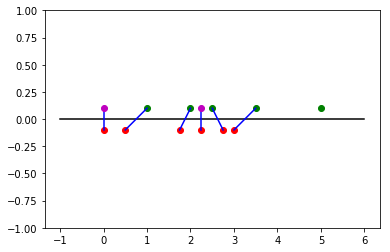

In [110]:
param_target_search_treshold = 1.25

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

tracks  = [1,2,2.5,3.5,5]
measure = [1.75,3,2.75,0.5,0,2.25]

# plot for visualization
end = np.max(np.concatenate((tracks,measure)))+1
start = np.min(np.concatenate((tracks,measure)))-1
plt.plot([start,end],[0,0],'-k')
plt.plot(tracks,np.ones(len(tracks))*0.1,'og')
plt.plot(measure,np.ones(len(measure))*-0.1,'or')
plt.ylim(-1,1)

func = lambda x: np.linalg.norm(x[0]-x[1])

# build cost matrix
max_dim = max(len(tracks),len(measure))
min_dim = min(len(tracks),len(measure))

measure_link = [None]*len(measure)
if min_dim > 0:
    cost = -np.ones((max_dim,max_dim)) # [i,j]:(track,measure)
    for i,t in enumerate(tracks):
        for j,m in enumerate(measure):
            dist = func((t,m))#np.linalg.norm(t-m)
            if dist < param_target_search_treshold:
                cost[i,j] = dist
            else:
                cost[i,j] = 100                
    t_link,m_link = linear_sum_assignment(cost)
    print(cost)
    print(t_link,m_link)

    for i in range(max_dim):
        if m_link[i] < len(measure):
            cost_link = cost[t_link[i],m_link[i]]
            if cost_link >= 0 and cost_link < param_target_search_treshold:
                measure_link[m_link[i]] = t_link[i]
                plt.plot([measure[m_link[i]],tracks[t_link[i]]],[-0.1,0.1],'-b')
            else: # negative cost from filler node (if cost_link < 0), inf cost from invalid connection
                plt.plot([measure[m_link[i]],measure[m_link[i]]],[-0.1,0.1],'-b')
                plt.plot(measure[m_link[i]],0.1,'om')
else:
    if len(tracks) == 0:
        for i in range(len(measure)):
            plt.plot([measure[i],measure[i]],[-0.1,0.1],'-b')
            plt.plot(measure[i],0.1,'om')
    else:
        # No measurements
        pass

print(measure_link)
print(measure)

In [4]:
from scipy.optimize import linear_sum_assignment
import numpy as np

A = [10,-40,-60]
B = [11,-45]

C = np.zeros((len(A),len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
        C[i,j] = abs(a-b)

linear_sum_assignment(C)
        

(array([0, 1]), array([0, 1]))

In [116]:
a = [1,2,3,4,5]
b = [0,1,3,4]

a = [a[i] for i in b]
print(a)

[1, 2, 4, 5]


In [121]:
dist_func_lam =  lambda x: np.linalg.norm(x[0]-x[1])

dist_func_lam((np.array([2,2,2]),np.array([1,1,1])))

np.abs(np.array([1,2,3]))

array([1, 2, 3])

In [125]:
import time

a = np.zeros(100)

for i in range(len(a)):
    a[i] = time.time()
    time.sleep(0.025)
    
b = a[12]

print(np.argmin(np.abs(a-b)))

print(np.zeros(100))

12
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
